<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/introduction-to-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-4-4.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# A Complete Project Example

In [67]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    #
    # calculate the g-mean for each threshold
    #
    gmeans = np.sqrt(tpr * (1-fpr))
    #
    # locate the index of the largest g-mean
    #
    ix = np.argmax(gmeans)
    
    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        
        #ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
        #           markersize=8, label='Decision Point')
        
        ax[1].plot(fpr[ix], tpr[ix], 'ro',
                   markersize=8, label='Decision Point')
        
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

#         print('#######################')
#         print('Evaluation metrics ####')
#         print('#######################')
#         print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')
#         print(f'Precision: {metrics.precision_score(y_test, y_pred):.4f}')
#         print(f'Recall (Sensitivity): {metrics.recall_score(y_test, y_pred):.4f}')
#         print(f'Specificity: {(tn / (tn + fp)):.4f}')
#         print(f'F1-Score: {metrics.f1_score(y_test, y_pred):.4f}')
#         print(f"Cohen's Kappa: {metrics.cohen_kappa_score(y_test, y_pred):.4f}")

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats


## Let's make a simple project from scratch ...

### Credit Card Default Dataset

In this chapter, we tackle a binary classification problem set in the financial industry. We
work with a dataset contributed to the UCI Machine Learning Repository (a very popular
data repository). The dataset used in this chapter was collected in a Taiwanese bank in October 2005. The
study was motivated by the fact that—at that time—more and more banks were giving cash
(and credit card) credit to willing customers. You can download the sample file [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

In [68]:
import pandas as pd

In [69]:
#
# Load credit_card_default.csv
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [70]:
column_dtypes = {'EDUCATION': 'category',
'MARRIAGE': 'category',
'SEX': 'category',
'PAYMENT_STATUS_SEP': 'category',
'PAYMENT_STATUS_AUG': 'category',
'PAYMENT_STATUS_JUL': 'category',
'PAYMENT_STATUS_JUN': 'category',
'PAYMENT_STATUS_MAY': 'category',
'PAYMENT_STATUS_APR': 'category'}

In [71]:
#df = pd.read_csv(path + 'credit_card_default.csv', index_col=0, na_values='')

In [72]:
df = pd.read_csv(path + 'credit_card_default.csv', index_col=0, na_values='', dtype=column_dtypes, sep=',')

In [73]:
df.head()

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,...,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,Unknown,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In this step, we separated the **features** from the
**target (label)** by using the pop method. It assigned the given column to the new variable, while
removing it from the source DataFrame.

In [74]:
X = df.copy()
y = X.pop('default_payment_next_month')

In the following, we provide a simplified description of the variables:

- limit_bal: The amount of the given credit (NT dollar)
- sex: Gender
- education: Level of education
- marriage: Marital status
- age: Age of the customer
- payment_status_{month}: Status of payments in one of the previous 6 months
- bill_statement_{month}: The amount of bill statements (NT dollars) in one of the previous 6 months
- previous_payment_{month}: The amount of previous payments (NT dollars) in one of the previous 6 months

The target variable indicates **whether the customer defaulted on the payment in the
following month**.

### Exploratory Data Analysis

In [75]:
df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1000000.0
age,29850.0,35.49,9.22,21.0,28.00,34.0,41.00,79.0
bill_statement_sep,30000.0,51223.33,73635.86,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_statement_aug,30000.0,49179.08,71173.77,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_statement_jul,30000.0,47013.15,69349.39,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_statement_jun,30000.0,43262.95,64332.86,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_statement_may,30000.0,40311.40,60797.16,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_statement_apr,30000.0,38871.76,59554.11,-339603.0,1256.00,17071.0,49198.25,961664.0
previous_payment_sep,30000.0,5663.58,16563.28,0.0,1000.00,2100.0,5006.00,873552.0
previous_payment_aug,30000.0,5921.16,23040.87,0.0,833.00,2009.0,5000.00,1684259.0


Plot the distribution of age and, additionally, split it by gender:

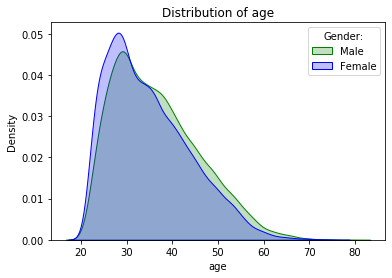

In [76]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#
# subplots return a figure and an array of axes. The Figure is the top level container for 
# all the plot elements while the axes class contains most of the figure elements: Axis, 
# Tick, Line2D, Text, Polygon, etc., and sets the coordinate system.
#
fig, ax = plt.subplots()

sns.distplot(df.loc[df.sex=='Male', 'age'].dropna(),
    hist=False, color='green',
    kde_kws={"shade": True},
    ax=ax, label='Male')

sns.distplot(df.loc[df.sex=='Female', 'age'].dropna(),
    hist=False, color='blue',
    kde_kws={"shade": True},
    ax=ax, label='Female')

ax.set_title('Distribution of age')
ax.legend(title='Gender:')

In [77]:
pivot = df.groupby("education")['default_payment_next_month']
pivot = pivot.value_counts(normalize=True).unstack()
pivot

default_payment_next_month,0,1
education,,
Graduate school,0.808200,0.191800
High school,0.748874,0.251126
Others,0.929336,0.070664
University,0.762321,0.237679


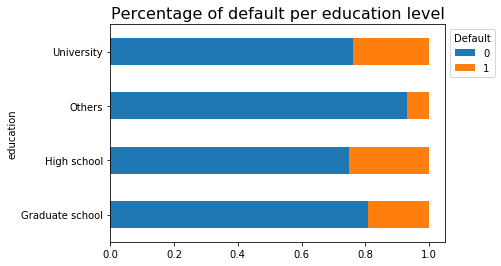

In [78]:
ax = pivot.plot(kind='barh', stacked='True')

ax.set_title('Percentage of default per education level', fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1))

### Splitting Data into Training and Test Sets

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

### Dealing with Missing Values

In [80]:
import missingno
from sklearn.impute import SimpleImputer

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             30000 non-null  int64  
 1   sex                   29850 non-null  object 
 2   education             29850 non-null  object 
 3   marriage              29850 non-null  object 
 4   age                   29850 non-null  float64
 5   payment_status_sep    30000 non-null  object 
 6   payment_status_aug    30000 non-null  object 
 7   payment_status_jul    30000 non-null  object 
 8   payment_status_jun    30000 non-null  object 
 9   payment_status_may    30000 non-null  object 
 10  payment_status_apr    30000 non-null  object 
 11  bill_statement_sep    30000 non-null  int64  
 12  bill_statement_aug    30000 non-null  int64  
 13  bill_statement_jul    30000 non-null  int64  
 14  bill_statement_jun    30000 non-null  int64  
 15  bill_statement_may 

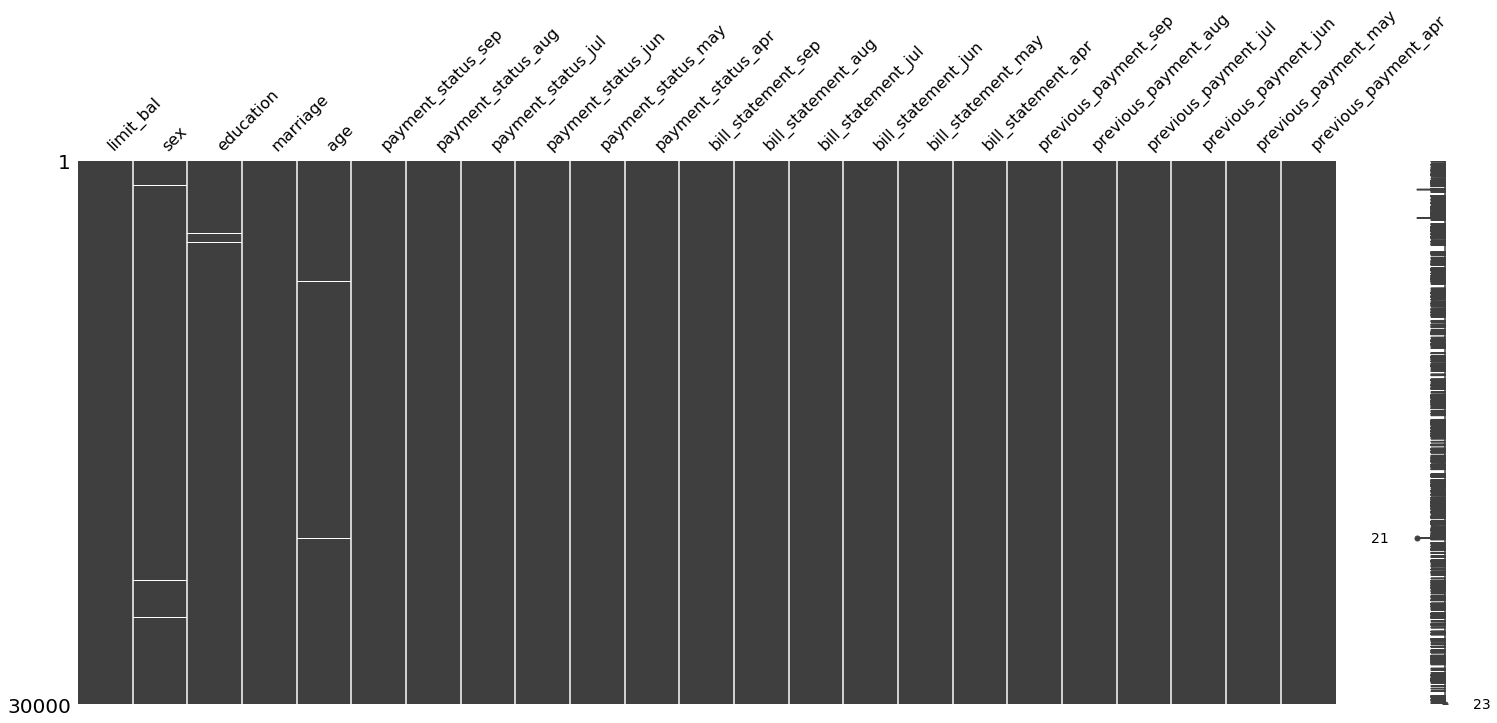

In [81]:
missingno.matrix(X)

In [82]:
NUM_FEATURES = ['age']
CAT_FEATURES = ['sex', 'education', 'marriage']

In [83]:
for col in NUM_FEATURES:
    num_imputer = SimpleImputer(strategy='median')
    num_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = num_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = num_imputer.transform(X_test[[col]])

In [84]:
for col in CAT_FEATURES:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = cat_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = cat_imputer.transform(X_test[[col]])

In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 21753 to 23654
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             24000 non-null  int64  
 1   sex                   24000 non-null  object 
 2   education             24000 non-null  object 
 3   marriage              24000 non-null  object 
 4   age                   24000 non-null  float64
 5   payment_status_sep    24000 non-null  object 
 6   payment_status_aug    24000 non-null  object 
 7   payment_status_jul    24000 non-null  object 
 8   payment_status_jun    24000 non-null  object 
 9   payment_status_may    24000 non-null  object 
 10  payment_status_apr    24000 non-null  object 
 11  bill_statement_sep    24000 non-null  int64  
 12  bill_statement_aug    24000 non-null  int64  
 13  bill_statement_jul    24000 non-null  int64  
 14  bill_statement_jun    24000 non-null  int64  
 15  bill_statement_

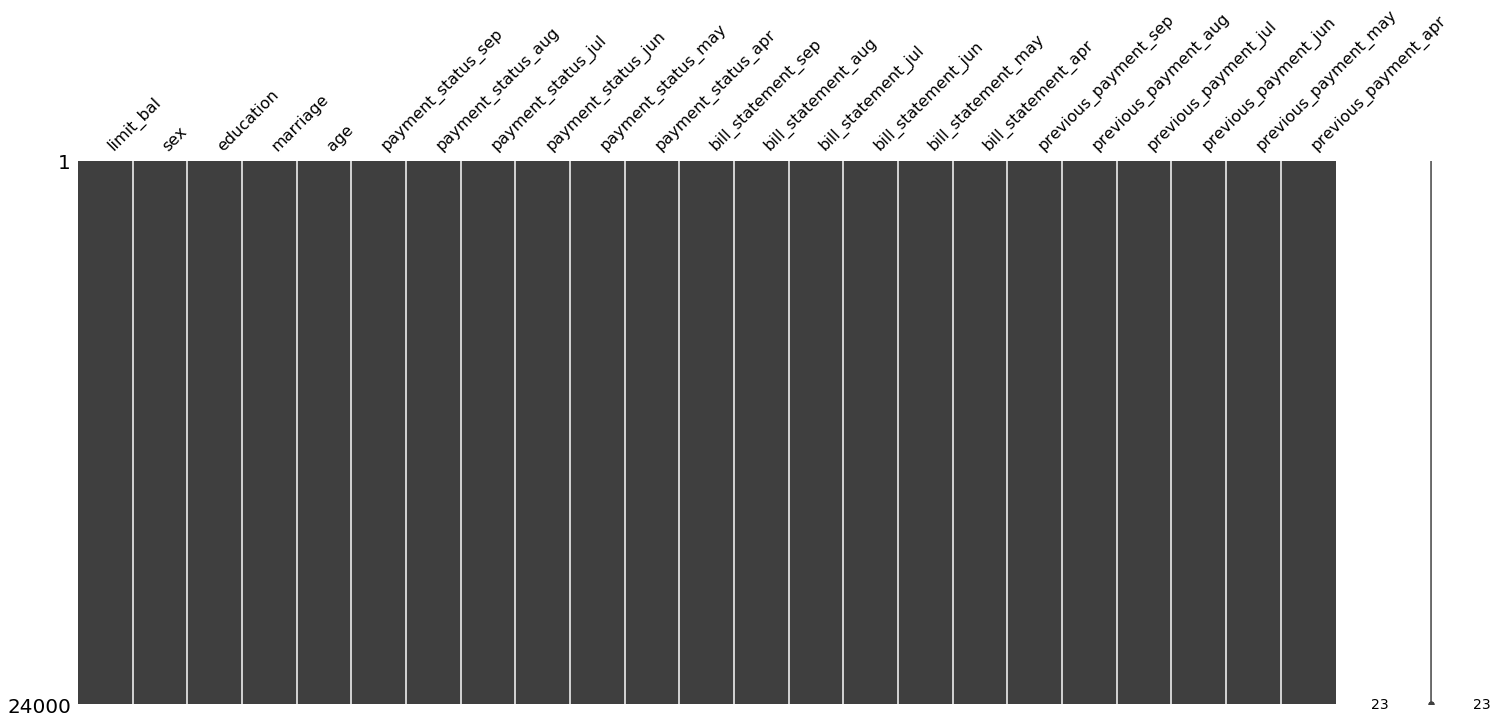

In [86]:
missingno.matrix(X_train)

### Encoding categorical variables

As we have already said, most machine learning algorithms work exclusively with numeric data. That is why we need to encode categorical features into a representation compatible with the models.

In this example, we cover some popular encoding approaches:

- Label encoding
- One-hot encoding

In label encoding, we replace the categorical value with a numeric value between $0$ and $(NrClasses - 1)$, for example, with three distinct classes, we use {0, 1, 2}. Let's how encode a categorical variable:

>**Preprocessing : sklearn.preprocessing**
>
>Before starting to train our machine learning models and make predictions, we usually need to do some preprocessing on our >raw data. Among some commonly used preprocessing tasks come OneHotEncoder, StandardScaler, MinMaxScaler, etc. These are >respectively for encoding of the categorical features into a one-hot numeric array, standardization of the features and >scaling each feature to a given range. Many other preprocessing methods are built-in this module.

>**ColumnTransformer : sklearn.compose**
>
>The ColumnTransformer is a class in the scikit-learn Python machine learning library that allows you to selectively apply >data preparation transforms. For example, it allows you to apply a specific transform or sequence of transforms to just >the numerical columns, and a separate sequence of transforms to just the categorical columns.

In [87]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

**Label Encoding**

In [88]:
COL = 'education'
#
# We created a copy of X_train and X_test, just to show how to work with LabelEncoder, but we do not 
# want to modify the DataFrames.
#
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

label_enc = LabelEncoder()
label_enc.fit(X_train_copy[COL])
X_train_copy.loc[:, COL] = label_enc.transform(X_train_copy[COL])
X_test_copy.loc[:, COL] = label_enc.transform(X_test_copy[COL])

In [89]:
X_train[COL]

21753         University
251           University
22941             Others
618      Graduate school
17090         University
              ...       
29802         University
5390     Graduate school
860      Graduate school
15795         University
23654         University
Name: education, Length: 24000, dtype: object

In [90]:
X_train_copy[COL]

21753    3
251      3
22941    2
618      0
17090    3
        ..
29802    3
5390     0
860      0
15795    3
23654    3
Name: education, Length: 24000, dtype: int32

**One-hot Encoding**

In [91]:
#
# Select categorical features for one-hot encoding:
#
CAT_FEATURES = X_train.select_dtypes(include='object') \
.columns \
.to_list()
CAT_FEATURES

['sex',
 'education',
 'marriage',
 'payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr']

In [92]:
#
#Instantiate the OneHotEncoder object:
#
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='error',drop='first')

In [93]:
#
# Create the column transformer using the one-hot encoder. To use the ColumnTransformer, you must specify a 
# list of transformers. Each transformer is a three-element tuple that defines the name of the transformer, 
# the transform to apply, and the column indices to apply it to. For example:
#
# (Name, Object, Columns)
#
one_hot_transformer = ColumnTransformer([("one_hot", one_hot_encoder, CAT_FEATURES)])

In [94]:
#
# Fit the transformer:
#
one_hot_transformer.fit(X_train)

ColumnTransformer(transformers=[('one_hot',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['sex', 'education', 'marriage',
                                  'payment_status_sep', 'payment_status_aug',
                                  'payment_status_jul', 'payment_status_jun',
                                  'payment_status_may',
                                  'payment_status_apr'])])

In [95]:
#
# Apply the transformations to both the training and the test set:

col_names = one_hot_transformer.get_feature_names()

X_train_cat = pd.DataFrame(one_hot_transformer.transform(X_train),columns=col_names,index=X_train.index)
X_train_ohe = pd.concat([X_train, X_train_cat], axis=1) .drop(CAT_FEATURES, axis=1)

X_test_cat = pd.DataFrame(one_hot_transformer.transform(X_test),columns=col_names,index=X_test.index)
X_test_ohe = pd.concat([X_test, X_test_cat], axis=1) .drop(CAT_FEATURES, axis=1)

In [96]:
X_train_ohe.head()

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,...,one_hot__x7_Payment delayed 8 months,one_hot__x7_Unknown,one_hot__x8_Payment delayed 2 months,one_hot__x8_Payment delayed 3 months,one_hot__x8_Payment delayed 4 months,one_hot__x8_Payment delayed 5 months,one_hot__x8_Payment delayed 6 months,one_hot__x8_Payment delayed 7 months,one_hot__x8_Payment delayed 8 months,one_hot__x8_Unknown
21753,80000,24.0,75125,77353,78321,73731,39643,39457,3503,5001,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
251,30000,28.0,29242,29507,29155,25255,22001,0,5006,1244,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22941,180000,44.0,20916,0,850,0,6881,10340,0,850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
618,60000,25.0,58839,53235,38533,39639,39619,39140,2018,1900,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17090,130000,25.0,111587,112348,114734,117823,120854,123904,4100,4200,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Fit a Decision Tree Classifier

In [97]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from sklearn import metrics
from io import StringIO
import seaborn as sns
from ipywidgets import Image
import pydotplus

In [113]:
tree_classifier = DecisionTreeClassifier(max_depth=3)
tree_classifier.fit(X_train_ohe, y_train)
y_pred = tree_classifier.predict(X_test_ohe)

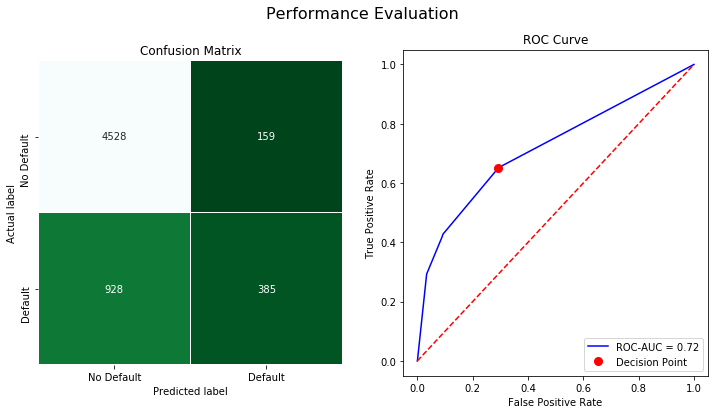

In [114]:
LABELS = ['No Default', 'Default']
tree_perf = performance_evaluation_report(tree_classifier,X_test_ohe,y_test, labels=LABELS,show_plot=True)

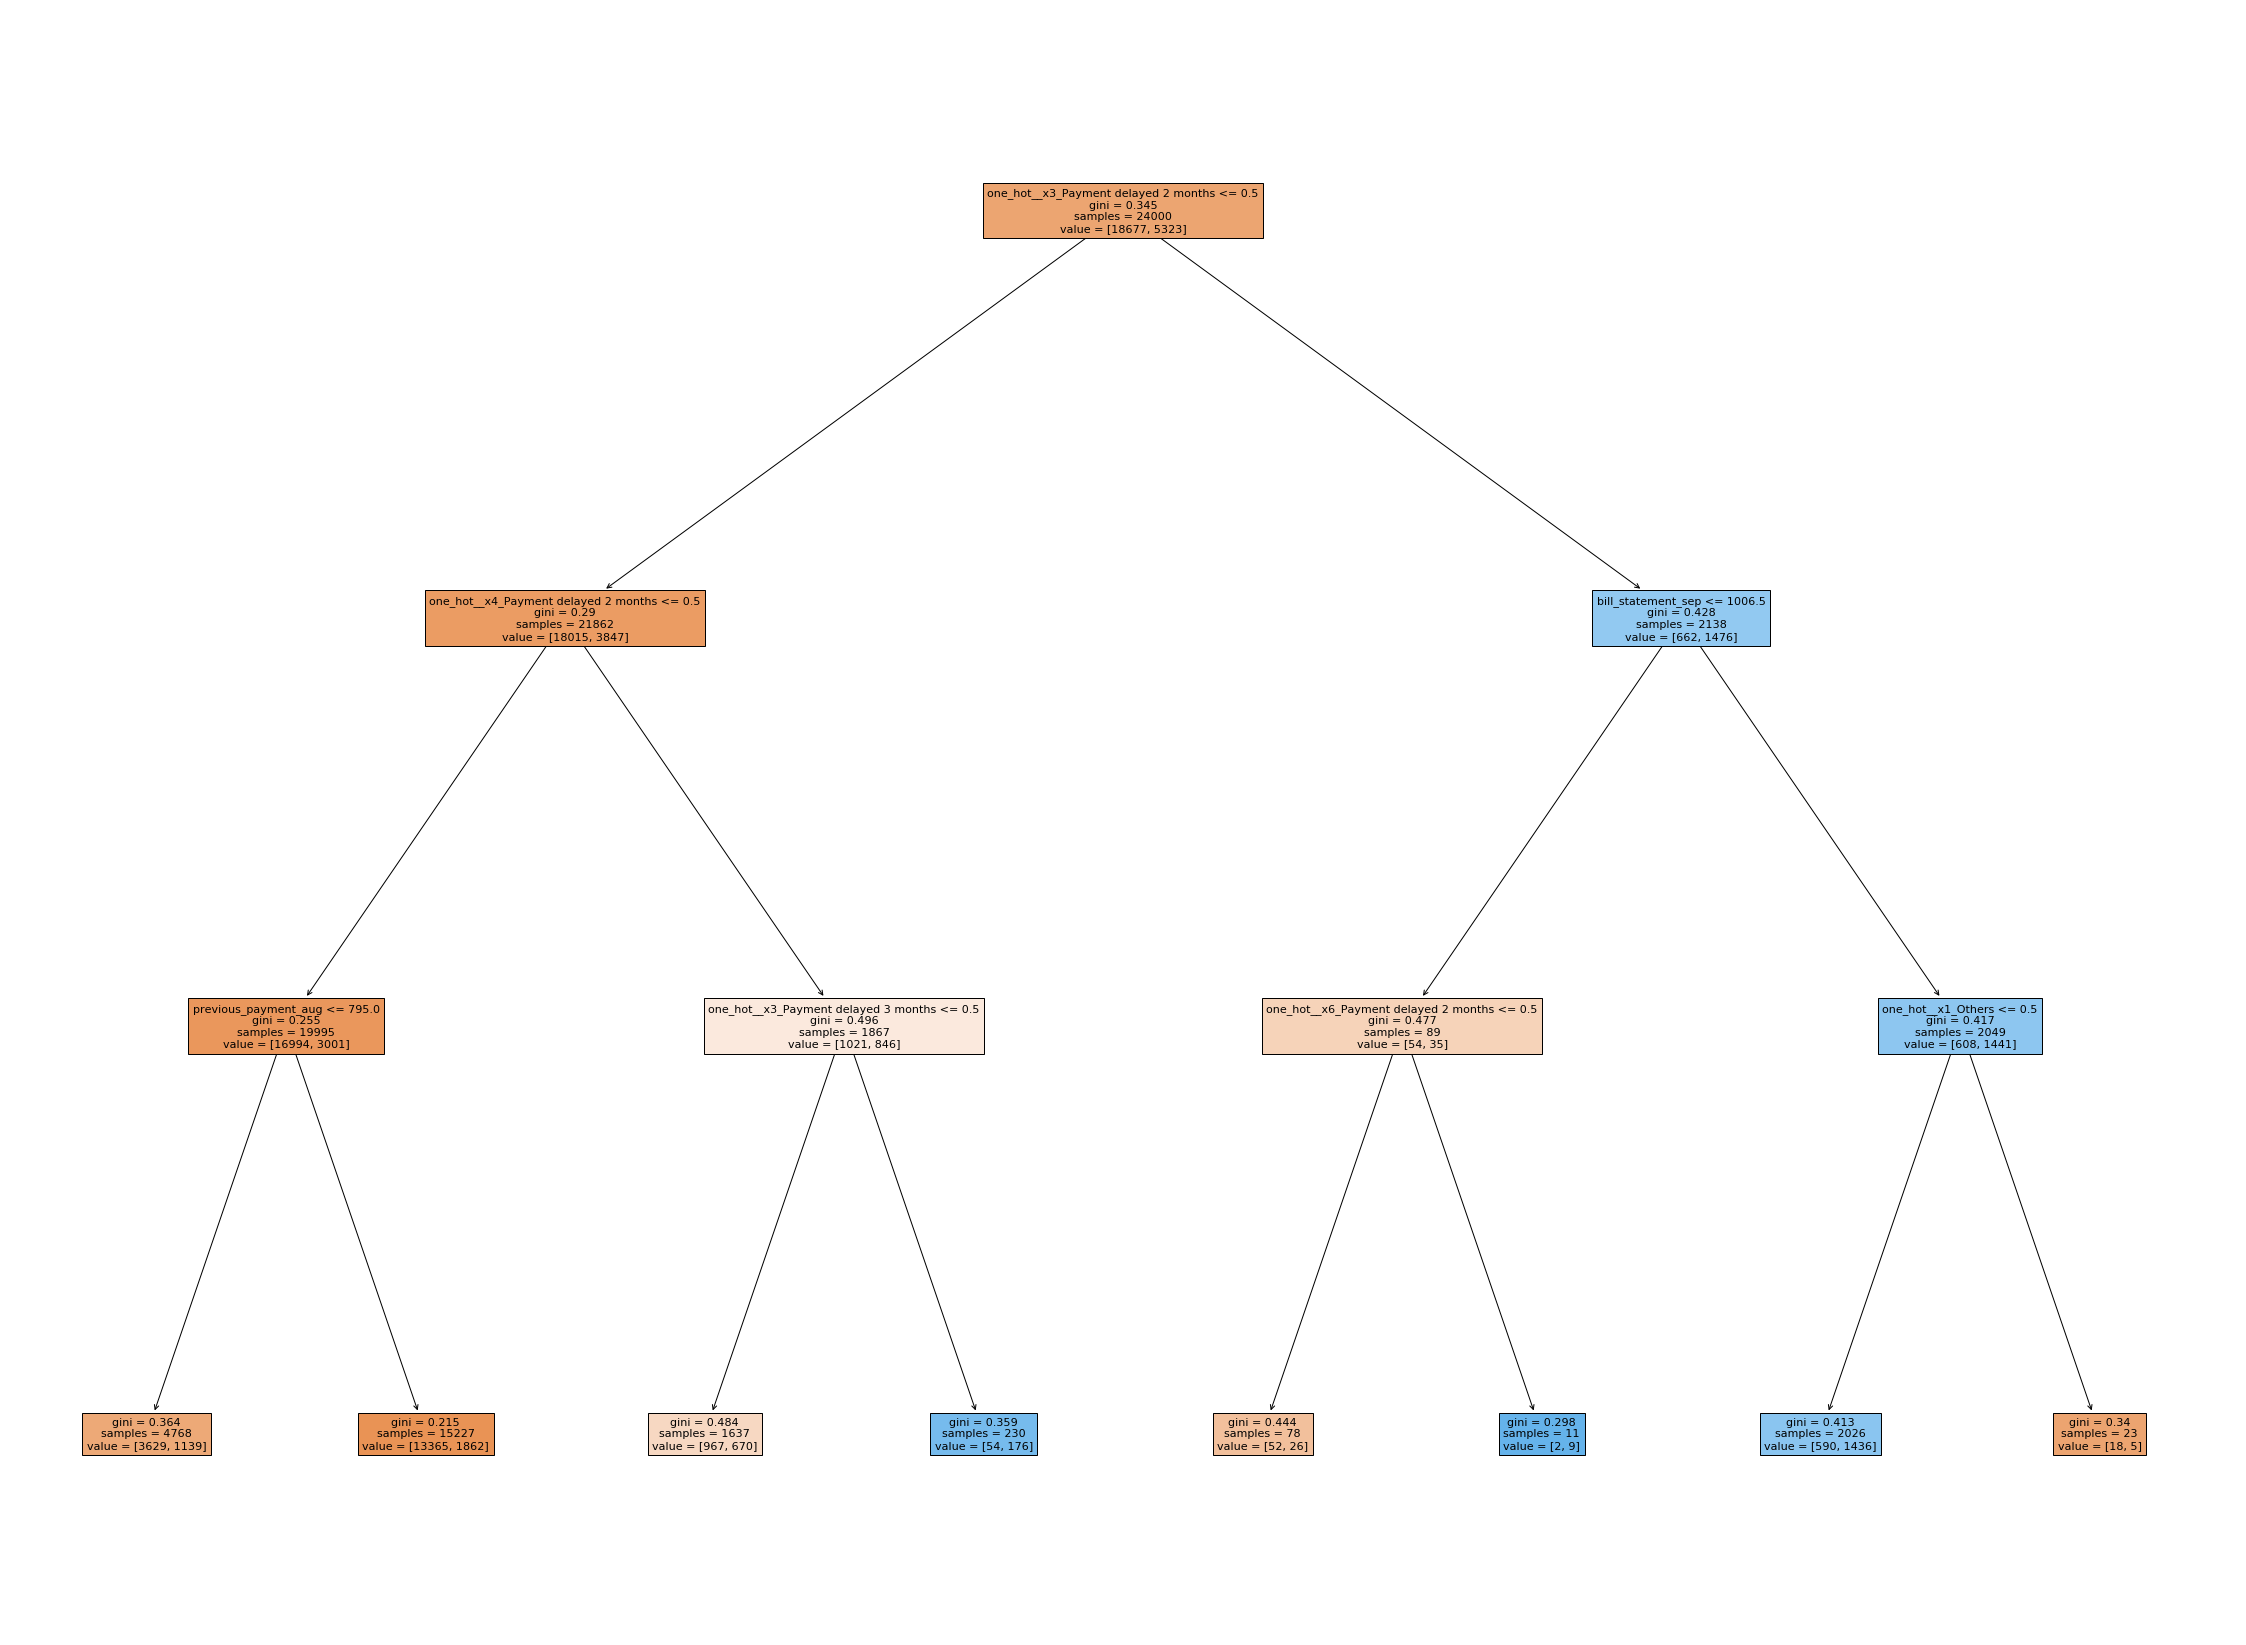

In [115]:
#small_tree = DecisionTreeClassifier(max_depth=3)
#small_tree.fit(X_train_ohe, y_train)

fig, ax = plt.subplots(figsize=(40, 30))
plot_tree(tree_classifier, filled=True, feature_names=X_train_ohe.columns, proportion=False)
plt.show()

## Tuning hyperparameters via grid search

In machine learning, we have two types of parameters: those that are learned
from the training data, for example, the weights in logistic regression, and the
parameters of a learning algorithm that are optimized separately. The latter are the
tuning parameters (or hyperparameters) of a model, for example, the regularization
parameter in logistic regression or the depth parameter of a decision tree.
In the previous section, we used validation curves to improve the performance of
a model by tuning one of its hyperparameters. In this section, we will take a look
at a popular hyperparameter optimization technique called grid search, which
can further help to improve the performance of a model by finding the optimal
combination of hyperparameter values.

In [116]:
from sklearn.model_selection import GridSearchCV

depth = [3,4,5,6,7,8]
param_grid =[{'max_depth':depth}]
    
gs = GridSearchCV(estimator=tree_classifier,
                  param_grid=param_grid,
                  scoring='accuracy', cv=10, refit=True,n_jobs=-1)      

In [117]:
gs = gs.fit(X_train_ohe, y_train)

In [118]:
print(gs.best_score_)

0.8185833333333333


In [119]:
print(gs.best_params_)

{'max_depth': 6}


### Now Use a Pipeline

The make_pipeline function takes an arbitrary number of scikit-learn transformers (objects that support the fit and transform methods as input), followed by a scikit- learn estimator that implements the fit and predict methods.

We can think of a scikit-learn Pipeline as a meta-estimator or wrapper around those individual transformers and estimators. If we call the fit method of Pipeline, the data will be passed down a series of transformers via fit and transform calls
on these intermediate steps until it arrives at the estimator object (the final element
in a pipeline). The estimator will then be fitted to the transformed training data. 

The make_pipeline function takes an arbitrary number of scikit-learn transformers
(objects that support the fit and transform methods as input), followed by a scikitlearn
estimator that implements the fit and predict methods.

In [120]:
#
# Import the libraries:
#
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [121]:
#
# Load credit_card_default.csv
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [122]:
#
# Load the data, separate the target, and create the stratified train-test split:
#
df = pd.read_csv(path + 'credit_card_default.csv', index_col=0, na_values='', dtype=column_dtypes, sep=',')

X = df.copy()
y = X.pop('default_payment_next_month')

#X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y, random_state=42)

In [123]:
#
# Store lists of numerical/categorical features:
#
num_features = X_train.select_dtypes(include='number').columns.to_list()
cat_features = X_train.select_dtypes(include='object').columns.to_list()

In [124]:
#
# Define the numerical Pipeline:
#
num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [125]:
#
# Define the categorical Pipeline:
#
cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                               ('onehot', OneHotEncoder(categories=cat_list, sparse=False,handle_unknown='error', drop='first'))
                              ])

In [126]:
# 
# Define the column transformer object:
#
preprocessor = ColumnTransformer(transformers=[('numerical', num_pipeline, num_features),
                                               ('categorical', cat_pipeline, cat_features)],remainder='drop')

In [151]:
#
# Create a joint Pipeline:
#
dec_tree      = DecisionTreeClassifier(max_depth=3)
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', dec_tree)])

In [152]:
#
# Fit the Pipeline to the data:
#
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['limit_bal', 'age',
                                                   'bill_statement_sep',
                                                   'bill_statement_aug',
                                                   'bill_statement_jul',
                                                   'bill_statement_jun',
                                                   'bill_statement_may',
                                                   'bill_statement_apr',
                                                   'previous_payment_sep',
                                                   'previous_payment_aug',
                                                   'previous_pa

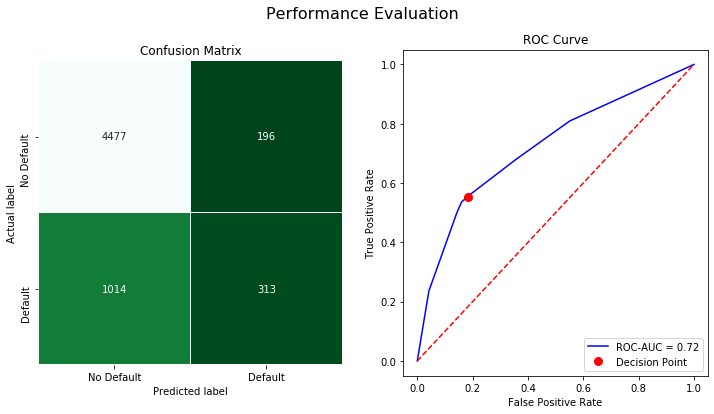

In [153]:
LABELS = ['No Default', 'Default']
tree_perf = performance_evaluation_report(tree_pipeline, X_test, y_test, labels=LABELS,show_plot=True)

## Model Performance and Cross-Validation 

This section is based on ***Raschka S. et al. "Machine Learning with Python", Chapter 6***.

One of the key steps in building a machine learning model is to estimate its
performance on data that the model hasn't seen before. Let's assume that we fit our
model on a training dataset and use the same data to estimate how well it performs on
new data. 

We remember from that a model can suffer from
**underfitting (high bias)** if the model is too simple, or it can **overfit** the training data
**(high variance)** if the model is too complex for the underlying training data.
To find an acceptable *bias-variance tradeoff*, we need to evaluate our model
carefully. In this section, you will learn about the common **cross-validation**
techniques holdout cross-validation and k-fold cross-validation, which can help
us to obtain reliable estimates of the model's generalization performance, that is,
how well the model performs on unseen data.

### Holdout Method

Using the holdout method, we
split our initial dataset into separate training and test datasets—the former is used
for model training, and the latter is used to estimate its generalization performance.
However, in typical machine learning applications, we are also interested in tuning
and comparing different parameter settings to further improve the performance for
making predictions on unseen data. This process is called model selection, with
the name referring to a given classification problem for which we want to select
the optimal values of tuning parameters (also called hyperparameters). However, if
we reuse the same test dataset over and over again during model selection, it will
become part of our training data and thus the model will be more likely to overfit.

A better way of using the holdout method for model selection is to separate the
data into three parts: a training dataset, a validation dataset, and a test dataset.
The training dataset is used to fit the different models, and the performance on the
validation dataset is then used for the model selection. The advantage of having
a test dataset that the model hasn't seen before during the training and model
selection steps is that we can obtain a less biased estimate of its ability to generalize
to new data. The following figure illustrates the concept of holdout cross-validation,
where we use a validation dataset to repeatedly evaluate the performance of the
model after training using different hyperparameter values. Once we are satisfied
with the tuning of hyperparameter values, we estimate the model's generalization
performance on the test dataset:

![chapter-4-5_pic_0.png](./pic/chapter-4-5_pic_0.png)
*From S. Raschka et al. (see Reference)*

### k-fold Cross-Validation

In k-fold cross-validation, we randomly split the training dataset into k folds without
replacement, where k – 1 folds are used for the model training, and one fold is used
for performance evaluation. This procedure is repeated k times so that we obtain k
models and performance estimates.

We then calculate the average performance of the models based on the different,
independent test folds to obtain a performance estimate that is less sensitive
to the sub-partitioning of the training data compared to the holdout method.
Typically, we use k-fold cross-validation for model tuning, that is, finding the
optimal hyperparameter values that yield a satisfying generalization performance,
which is estimated from evaluating the model performance on the test folds.
Once we have found satisfactory hyperparameter values, we can retrain the model
on the complete training dataset and obtain a final performance estimate using the
independent test dataset. The rationale behind fitting a model to the whole training
dataset after k-fold cross-validation is that providing more training examples to
a learning algorithm usually results in a more accurate and robust model.

![chapter-4-5_pic_1.png](./pic/chapter-4-5_pic_1.png)
*From S. Raschka et al. (see Reference)*

In [154]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=tree_pipeline,X=X_train,y=y_train,cv=10,n_jobs=1)

In [155]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.80041667 0.79291667 0.8075     0.80208333 0.7975     0.80666667
 0.80416667 0.80291667 0.8        0.79416667]


In [156]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.801 +/- 0.005


## Validation Curves

The graph in the upper-left (reported below) shows a model with high bias. This model has both low
training and cross-validation accuracy, which indicates that it underfits the training
data. Common ways to address this issue are to increase the number of parameters
of the model, for example, by collecting or constructing additional features, or by
decreasing the degree of regularization, for example, in support vector machine
(SVM) or logistic regression classifiers.
The graph in the upper-right shows a model that suffers from high variance, which
is indicated by the large gap between the training and cross-validation accuracy.
To address this problem of overfitting, we can collect more training data, reduce
the complexity of the model, or increase the regularization parameter, for example.

![image.png](./pic/chapter-4-4_pic_22.png)

In [157]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
    learning_curve(estimator=tree_pipeline,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1)

In [158]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

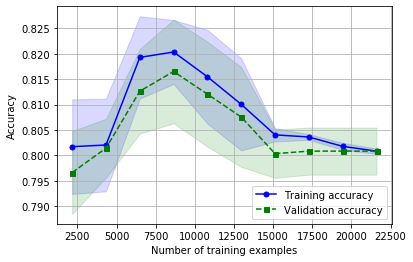

In [159]:
plt.plot(train_sizes, train_mean,
    color='blue', marker='o',
    markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=5,
    label='Validation accuracy')

plt.fill_between(train_sizes,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# References

*Eryk Lewinson*, "**Python For Finance Cookbook**",  Packt Publishing (2020)

*Sebastian Raschka and Vahid Mirjalili* "**Machine Learning with Python**", 3rd edition, Packt Publishing